<a href="https://colab.research.google.com/github/ritwikraha/GenerativeFill-with-Keras-and-Diffusers/blob/main/imagediting_through_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Editing Through Text

Using Keras CV, HuggingFace Diffusers, and Transformers to create a pipeline for editing images based on *just* the text prompt supplied.



## Installations and Imports

In [1]:
!pip install --upgrade -qq keras-cv tensorflow
!pip install --upgrade -qq keras

!pip install --upgrade -qq diffusers accelerate transformers

!pip install --upgrade -qq git+https://github.com/IDEA-Research/GroundingDINO.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0.post1 requires keras<2.16,>=2.15.0, but you have keras 3.0.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 94.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget -q https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/v0.1.0-alpha2/groundingdino/config/GroundingDINO_SwinT_OGC.py

In [3]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import keras
from keras import ops
import keras_cv


from diffusers import AutoPipelineForInpainting
from groundingdino.util.inference import Model as GroundingDINO
from transformers import AutoTokenizer, AutoModelForCausalLM

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
GDINO_CONFIG_PATH = "GroundingDINO_SwinT_OGC.py"
GDINO_WEIGHTS_PATH = "groundingdino_swint_ogc.pth"
SAM_MODEL_NAME = "sam_huge_sa1b"

IMAGE_SIZE = (1024, 1024)

## Get the Image

1483856/1483856 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


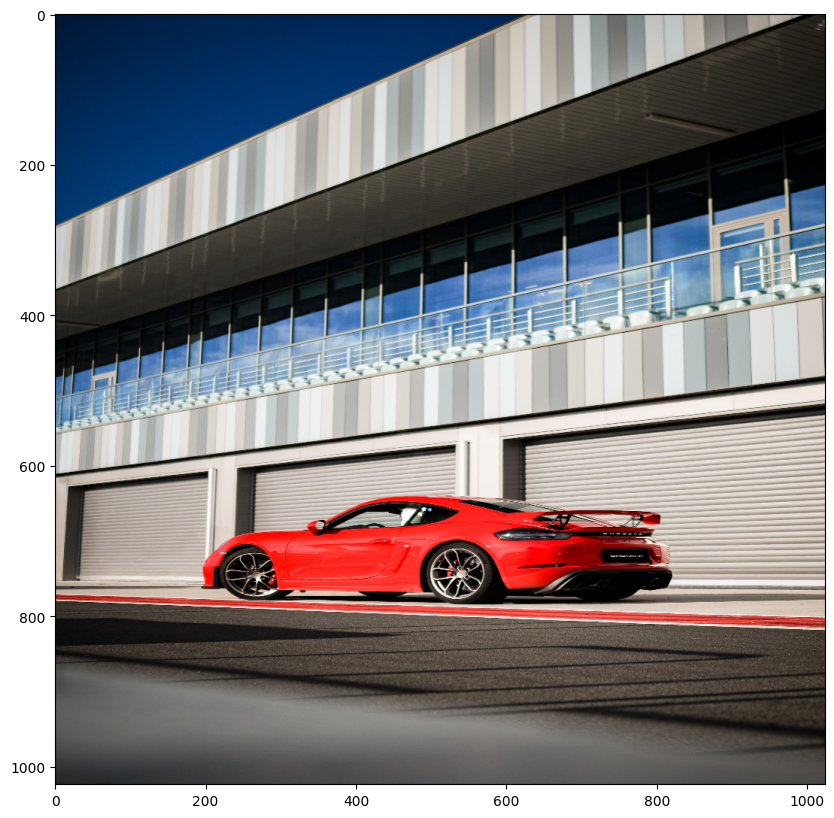

In [5]:
image_url = "https://i.imgur.com/7zWdoN1.jpg"
filepath = keras.utils.get_file(origin=image_url)
image = np.array(keras.utils.load_img(filepath))
image = ops.convert_to_numpy(ops.image.resize(image[None, ...], IMAGE_SIZE)[0])

plt.figure(figsize=(10, 10))
plt.imshow(image / 255.0)
plt.axis("on")
plt.show()

## Get the Text  

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-chat-hf")
model = AutoModelForCausalLM.from_pretrained("NousResearch/Llama-2-7b-chat-hf").to(device)

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [9]:
# @title What do you want to do? { run: "auto", form-width: "100px" }
input_prompt = "Replace the car with a truck" # @param {type:"string"}


In [10]:
messages = [
    {"role": "system", "content": "Follow the examples and return the expected output"},
    {"role": "user", "content": "Swap mountain and lion"},  # example 1
    {"role": "assistant", "content": "mountain, lion"},  # example 1
    {"role": "user", "content": "Change the dog with cat"},  # example 2
    {"role": "assistant", "content": "dog, cat"},  # example 2
    {"role": "user", "content": "Replace X with Y"},  # example 3
    {"role": "assistant", "content": "X, Y"},  # example 3
    {"role": "user", "content": "Change the background with a forest"},  # example 4
    {"role": "assistant", "content": "background, forest"},  # example 4
    {"role": "user", "content": "Change man with a cartoon"},  # example 5
    {"role": "assistant", "content": "man, cartoon"},  # example 5
    {"role": "user", "content": input_prompt}
]

input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt")

generated_ids = model.generate(input_ids.to(device), max_new_tokens=1000, do_sample=True)
outputs = tokenizer.batch_decode(generated_ids)


No chat template is defined for this tokenizer - using the default template for the LlamaTokenizerFast class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



In [11]:
outputs

['<s>[INST] <<SYS>>\nFollow the examples and return the expected output\n<</SYS>>\n\nSwap mountain and lion [/INST] mountain, lion</s><s>[INST] Change the dog with cat [/INST] dog, cat</s><s>[INST] Replace X with Y [/INST] X, Y</s><s>[INST] Change the background with a forest [/INST] background, forest</s><s>[INST] Change man with a cartoon [/INST] man, cartoon</s><s>[INST] Replace the car with a truck [/INST] car, truck</s>']

In [12]:
data = outputs[0].split("[/INST]")[-1].split("</s>")[0].split(",")
target_object = data[0].strip()  # Remove leading/trailing spaces
replacement = data[1].strip()

print(f"object: {target_object}")
print(f"replacement: {replacement}")

object: car
replacement: truck


## Utilities

In [13]:
def show_mask(mask, ax):
    color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    box = box.reshape(-1)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )

## Get the Model

In [14]:
sam_model = keras_cv.models.SegmentAnythingModel.from_preset(SAM_MODEL_NAME)
grounding_dino = GroundingDINO(GDINO_CONFIG_PATH, GDINO_WEIGHTS_PATH)

100%|██████████| 3.38k/3.38k [00:00<00:00, 4.94MB/s]
100%|██████████| 2.39G/2.39G [02:34<00:00, 16.6MB/s]
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Segmentation based on Text Input

In [15]:
object_name = target_object

# Grounding DINO
boxes = grounding_dino.predict_with_caption(
    image.astype(np.uint8),
    object_name,
)
boxes = np.array(boxes[0].xyxy)

# SAM
outputs = sam_model.predict(
    {
        "images": np.repeat(image[np.newaxis, ...], boxes.shape[0], axis=0),
        "boxes": boxes.reshape(-1, 1, 2, 2),
    },
    batch_size=1,
)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:993: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


## Show the Segmentation

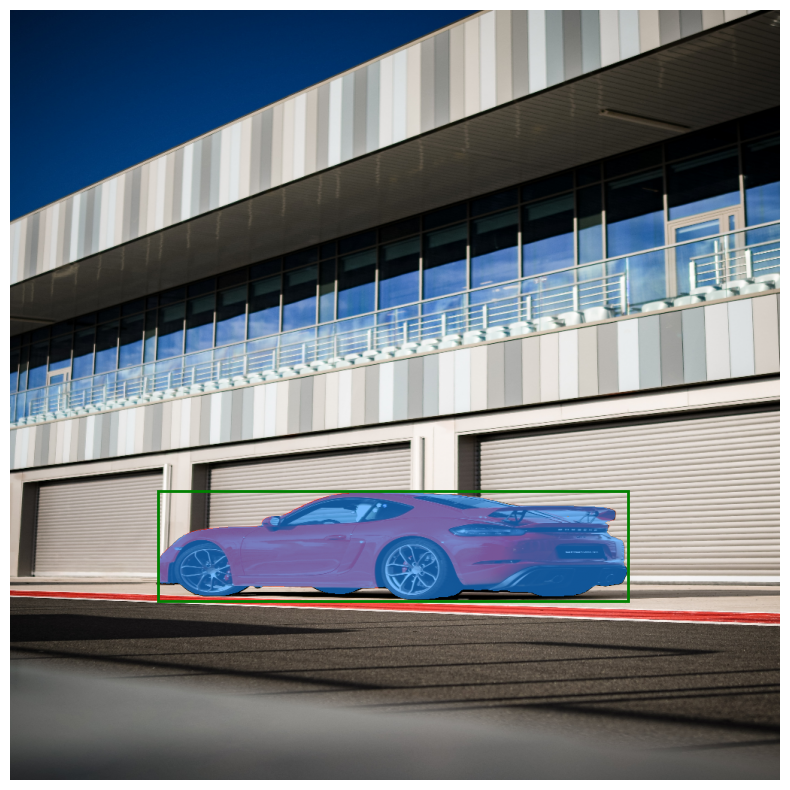

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(image / 255.0)

for mask in outputs["masks"]:
    mask = ops.image.resize(mask[0][..., None], IMAGE_SIZE)[..., 0]
    mask = ops.convert_to_numpy(mask) > 0.0
    show_mask(mask, plt.gca())
    show_box(boxes, plt.gca())

plt.axis("off")
plt.show()

# Image Editing using Inpainting

In [17]:
pipeline = AutoPipelineForInpainting.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
    variant="fp16",
)
pipeline.enable_model_cpu_offload()

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Creating the Prompt based on Text Input

In [18]:
prompt = f"""A {replacement}  illuminated by soft, warm light,
in breathtakingly high detail and vivid 8K resolution. Focus on intricate textures,
subtle light and shadow interplay, and a stunning composition that draws the viewer's eye.
Capture a sense of joy and evoke a feeling of satisfaction while maintaining
realistic proportions and natural colors. Render in a realistic style
reminiscent of modern photography with a focus on artistic expression and visual harmony."""

negative_prompt = """lowres, bad anatomy, bad hands,
text, error, missing fingers, extra digit, fewer digits,
cropped, worst quality, low quality"""

output = pipeline(
    prompt=prompt,
    image=Image.fromarray(image.astype(np.uint8)),
    mask_image=Image.fromarray(mask),
    negative_prompt=negative_prompt,
    guidance_scale=7.5,
    strength=0.6
).images[0]

Token indices sequence length is longer than the specified maximum sequence length for this model (85 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['focus on artistic expression and visual harmony.']


  0%|          | 0/30 [00:00<?, ?it/s]

## Ta-Daa!

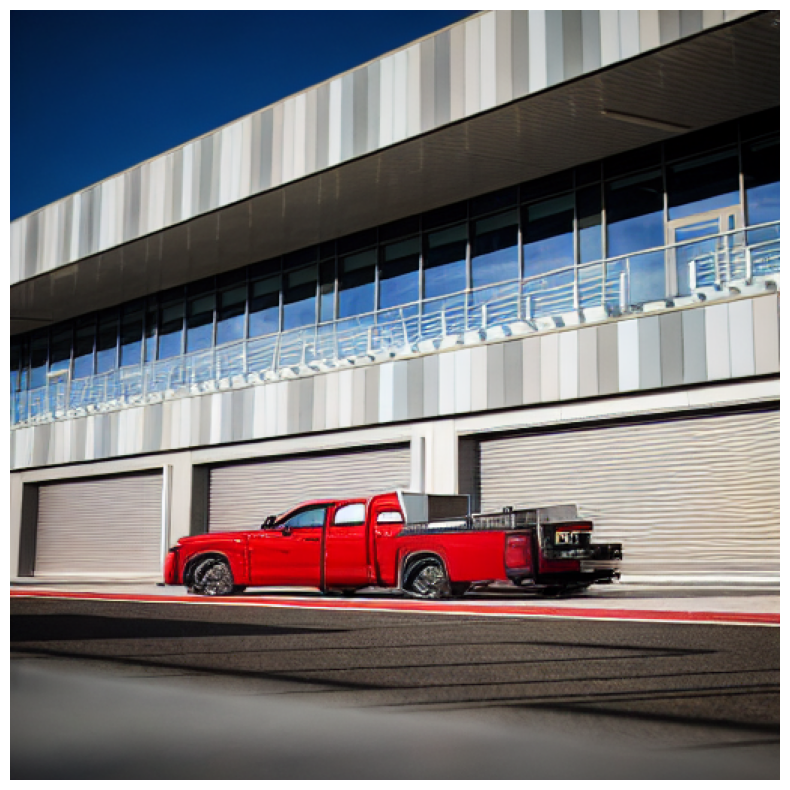

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(output)
plt.axis("off")
plt.show()